# Vehicle Detection and Tracking
The goal of this project is to write a software pipeline to detect vehicles in a video (starting with the test_video.mp4 and later implementing on full project_video.mp4)

The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
2. Optionally, we can also apply a color transform and append binned color features, as well as histograms of color, to our HOG feature vector.
    Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
3. Implement a sliding-window technique and use our trained classifier to search for vehicles in images.
4. Run our pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
5. Estimate a bounding box for vehicles detected.

Most of the code here is used from the lecture exercies.

In [1]:
# Import required libraries
import cv2
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC

%matplotlib inline

C:\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Test Draw boxes

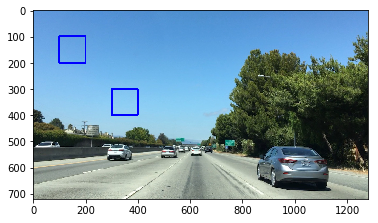

In [2]:
def getRGBImage(bgrImage):
    rgbImage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgbImage

def drawBoxes(image, bBoxes, color=(0, 0, 255), thickness = 6):
    for bBox in bBoxes:
        cv2.rectangle(image, bBox[0], bBox[1], color, thickness)
    return image

image = cv2.imread('test_images/bbox-example-image.jpg')
rgbImage = getRGBImage(image)
bBoxes = [((100, 100), (200, 200)), ((300, 300), (400, 400))]
result = drawBoxes(rgbImage, bBoxes)
plt.imshow(result)
plt.show()

## Spatial binning of color and Color Histogram

In [3]:
# Spatial binning of the image
def binSpatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
        
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel()
    
    return features

# Generating a color histogram
def colorHistogram(img, nbins = 32, binRange = (0, 256)):
    # Calculate RGB hists
    redHist   = np.histogram(img[:, :, 0], nbins, binRange)
    greenHist = np.histogram(img[:, :, 1], nbins, binRange)
    blueHist  = np.histogram(img[:, :, 2], nbins, binRange)
    
    # Find edges and center
    binEdges   = redHist[1]
    binCenters = (binEdges[1:] + binEdges[0:len(binEdges) - 1])/2
    
    #Concatenate the features
    histFeatures = np.concatenate((redHist[0], greenHist[0], blueHist[0]))
    
    return redHist, greenHist, blueHist, binCenters, histFeatures

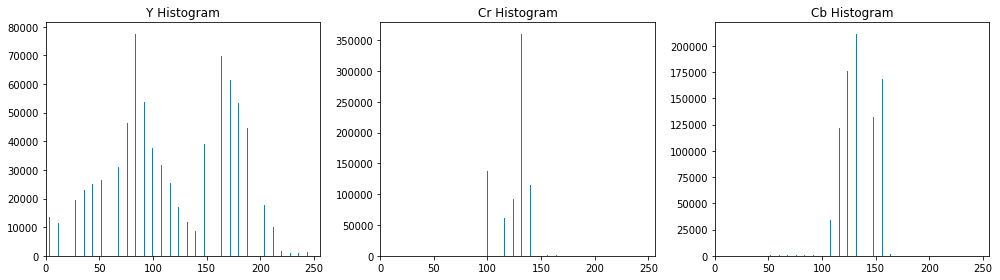

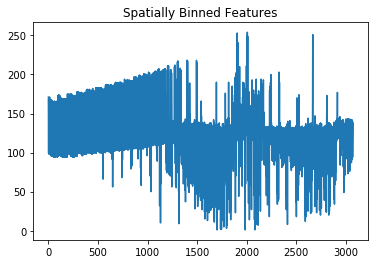

In [4]:
# Read a test image at random
image = cv2.imread('test_images/test4.jpg')
rgbImage = getRGBImage(image)
ycrcb = cv2.cvtColor(rgbImage, cv2.COLOR_RGB2YCrCb)

# Perform spatial binning
feature_vec = binSpatial(image, color_space='YCrCb', size=(32, 32))

# Get color histograms
redHist, greenHist, blueHist, binCenters, histFeatures = colorHistogram(ycrcb, nbins = 32, binRange = (0, 256))

if redHist is not None:
    fig = plt.figure(figsize=(14, 4))
    
    # Plot Y histogram
    plt.subplot(131)
    plt.bar(binCenters, redHist[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    
    # Plot Cr histogram
    plt.subplot(132)
    plt.bar(binCenters, greenHist[0])
    plt.xlim(0, 256)
    plt.title('Cr Histogram')
    
    # Plot Cb histogram
    plt.subplot(133)
    plt.bar(binCenters, blueHist[0])
    plt.xlim(0, 256)
    plt.title('Cb Histogram')
    
    # Save the image
    fig.tight_layout()
    plt.savefig('output_images/ColorHists.png')
    plt.show()    
else:
    print('Function returned None.')

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.savefig('output_images/SpatialFeatures.png')
plt.show()

## Data Exploration

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


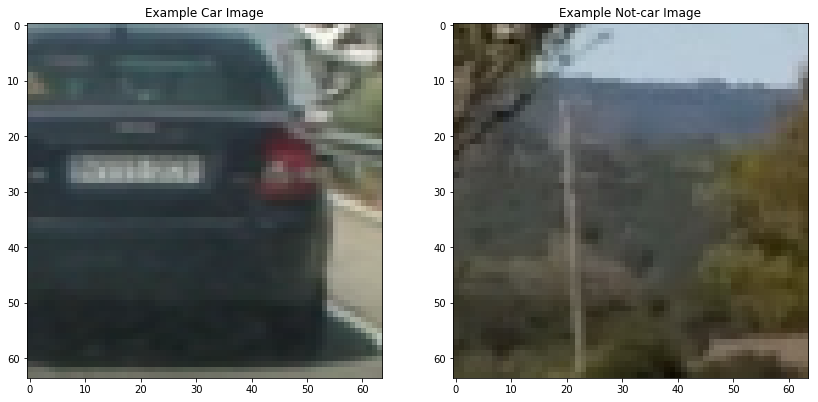

In [5]:
# Import all the images using Glob
## Vehicles Images
GTI_Far         = glob.glob('vehicles\GTI_Far\*.png')
GTI_Left        = glob.glob('vehicles\GTI_Left\*.png')
GTI_MiddleClose = glob.glob('vehicles\GTI_MiddleClose\*.png')
GTI_Right       = glob.glob('vehicles\GTI_Right\*.png')
KITTI_Extracted = glob.glob('vehicles\KITTI_extracted\*.png')

## Non-Vehicles Images
Extras = glob.glob('non-vehicles\Extras\*.png')
GTI    = glob.glob('non-vehicles\GTI\*.png')

# Initialize variables
cars    = np.concatenate((GTI_Far, GTI_Left, GTI_MiddleClose, GTI_Right, KITTI_Extracted))
notcars = np.concatenate((GTI, Extras))
        
# Define a function to return some characteristics of the dataset 
def dataLook(car_list, notcar_list):
    data_dict = {}
    
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    
    # Read in a test image, either car or notcar
    example_img = cv2.imread(car_list[0])
    
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    
    # Return data_dict
    return data_dict
    
data_info = dataLook(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

# Save the output image
TF = mpimg.imsave('output_images/carImage.png', car_image)
TF = mpimg.imsave('output_images/notCarImage.png', notcar_image)

## HOG Features

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


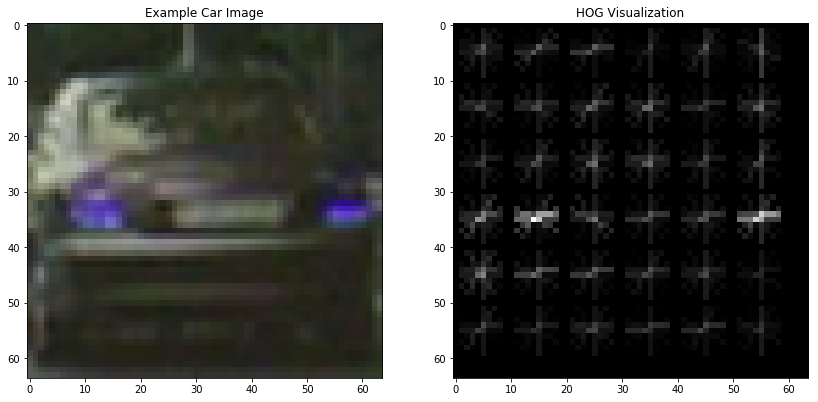

In [6]:
# Define a function to return HOG features and visualization
def getHogFeatures(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))

# Read in the image
image    = cv2.imread(cars[ind])
rgbImage = getRGBImage(image)
gray     = cv2.cvtColor(rgbImage, cv2.COLOR_RGB2GRAY)
ycrcb    = cv2.cvtColor(rgbImage, cv2.COLOR_RGB2YCrCb)
gray     = ycrcb[:, :, 2]

# Define HOG parameters
orient = 9
pix_per_cell = 10
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image = getHogFeatures(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# Save the output image
TF = mpimg.imsave('output_images/hogCarImage.png', image )
TF = mpimg.imsave('output_images/hogFeatures.png', hog_image, cmap='gray' )

## Combine and Normalize Features

Up until now we have using the functions shown in lecture videos and implementing them 1 at a time. We will now create a consolidated version of all those functions and create an "Extract Features" function to combine and normalize all the features, as shown in the lecture

In [7]:
# Define a function to compute Color Histogram
def color_hist(img, nbins = 32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins = nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins = nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins = nbins)
    
    # Concatenate into single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the features
    return hist_features

# Define a function to binned Color features
def bin_spatial(img, size = (32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False,
                    feature_vec=True):
    # Call the two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations = orient,
                                 pixels_per_cell = (pix_per_cell, pix_per_cell),
                                 cells_per_block = (cell_per_block, cell_per_block),
                                 transform_sqrt = False, visualise = vis,
                                 feature_vector = feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations = orient,
                       pixels_per_cell = (pix_per_cell, pix_per_cell),
                       cells_per_block = (cell_per_block, cell_per_block),
                       transform_sqrt = False, visualise = vis,
                       feature_vector = feature_vec)
        return features

# Define a function to Combine and Normalize the features
def extract_features(imgs, color_space = 'RGB', spatial_size = (32, 32),
                    hist_bins = 32, orient = 9, pix_per_cell = 10,
                    cell_per_block = 2, hog_channel = 0, spatial_feat = True,
                    hist_feat = True, hog_feat = True):
    # Initialize the variables
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        # Get Spatial Features and append them to file features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        # Get Color Hist and append them to file features
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins = hist_bins)
            file_features.append(hist_features)
        
        # Get HOG Features and append them to file features
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                        orient, pix_per_cell,
                                                        cell_per_block, vis=False,
                                                        feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                               pix_per_cell, cell_per_block, vis=False,
                                               feature_vec=True)
            # Append the new features
            file_features.append(hog_features)
        
        # Append to the main features list
        features.append(np.concatenate(file_features))
    
    # Return the list of features
    return features

# Define a function to draw boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    # Return the image
    return imcopy

## Sliding Window

Now, it will be useful to have a function to perform a sliding window search on an image. This function plots a rectangle at each window position.

Our goal here is to write a function that takes in an image, start and stop positions in both x and y (imagine a bounding box for the entire search region), window size (x and y dimensions), and overlap fraction (also for both x and y). Our function should return a list of bounding boxes for the search windows, which will then be passed to draw draw_boxes() function.

In [8]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer  = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer  = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx   = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy   = starty + xy_window[1]
           
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list

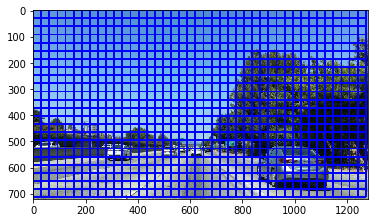

In [9]:
# Visualize Sliding Window
image = mpimg.imread('test_images/bbox-example-image.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None],
                xy_window=(62, 62), xy_overlap=(0.5, 0.5))
# Draw boxes
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
plt.imshow(window_img)

## Search windows
Define a function you will pass an image and the list of windows to be searched (output of slide_windows()). This code is imported from lecture notes directly but may not be used anywhere throughout this project.

In [10]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=10, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    #8) Return windows for positive detections
    return on_windows

## Classification of Cars vs Non-Cars
Using the extracted features we now use linear SVC to create a classifer to classify car vs non-car data

In [11]:
# Define variables required
color_space    = 'YCrCb'     # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9           # HOG orientations
pix_per_cell   = 10           # HOG pixels per cell
cell_per_block = 2           # HOG cells per block
hog_channel    = 'ALL'       # Can be 0, 1, 2, or "ALL"
spatial_size   = (32, 32)    # Spatial binning dimensions
hist_bins      = 64          # Number of histogram bins
spatial_feat   = True        # Spatial features on or off
hist_feat      = True        # Histogram features on or off
hog_feat       = True        # HOG features on or off
y_start_stop   = [None, None]  # Min and max in y to search in slide_window()

# Extract Car Features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Extract Non-Car Features
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Stack the features together
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scalar and apply the scalar to X
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                   test_size = 0.2, random_state=rand_state)

# Create a classification model and train it
svc = LinearSVC()
t1  = time.time()
svc.fit(X_train, y_train)
t2  = time.time()
 
# Print required information
print('1. Using', orient, 'orientations,', pix_per_cell, 'pixels per cell and',
     cell_per_block, 'cells per block')
print('2. Feature vector Length:', len(X_train[0]))
print('3.', round(t2-t1, 2), 'Seconds to train the SVC ...')
print('4. Test Accuracy of SVC:', round(svc.score(X_test, y_test), 4))

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1. Using 9 orientations, 10 pixels per cell and 2 cells per block
2. Feature vector Length: 5964
3. 14.8 Seconds to train the SVC ...
4. Test Accuracy of SVC: 0.9885


## Find Cars
The find_cars only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

In [12]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
              cell_per_block, spatial_size, hist_bins):
    
    # Initialize the variables and process the image.
    bBoxes          = []    
    draw_img        = np.copy(img)
    img             = img.astype(np.float32)/255    
    img_tosearch    = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    # Resize the image if required
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # Extract individual channels out.
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks        = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks        = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window             = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step     = 2  # Instead of overlap, define how many cells to step
    nxsteps            = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps            = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1    = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2    = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3    = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop  = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features    = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw  = np.int(window*scale)
                bBoxes.append(((xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bBoxes

## Run find_cars() on a test image

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


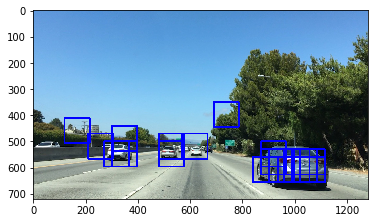

In [13]:
# Read the image
img = mpimg.imread('test_images/bbox-example-image.jpg')

# Initialize variables
ystart = 350
ystop  = 700
scale  = 1.5

# Run find_cars()
outputImage, reqBoxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# Save and image and display it
mpimg.imsave('output_images/bbox-example-image.png', outputImage)
plt.imshow(outputImage)
plt.show()

## Helper function
Here we add Add_heat, Apply_threshold and draw_labeled_bboxes functions provided in the class

In [14]:
def add_heat(heatmap, bbox_list):    
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Pipeline
Create a pipeline that uses the functions and workflows that we have defined above.
We will then test this pipeline on test images and finally on the project video

In [15]:
def pipeline(image):
    
    # Define scales and Y Start-Stop
    scales = np.arange(1.0, 2.5, ((2.5-1.0)/6))
    #scales = 1.5
    y_start_stops = []
    #y_start_stops = [300, 700]
    for scale in scales:
        y_start_stops.append([300, 700])
    
    bbox_list   = []
        
    # Define varialbes required for pipeline
    global heatmap_sum
    global heatmaps
    
    heat_thresh = 2
    for scale, y_start_stop in zip(scales, y_start_stops):
        drawnImg, boxes = find_cars(image, int(y_start_stop[0]), int(y_start_stop[1]), scale, svc,
                                    X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)    
        if not boxes == None:
            if not len(boxes) == 0:
                bbox_list.append(boxes)
            
            
    if(len(bbox_list) != 0):
        bbox_list = np.concatenate(bbox_list)
        
    # Get the heatmap values.
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in the box list
    heatmap = add_heat(heatmap, bbox_list)
    heatmaps.append(heatmap)
    heatmapSum = heatmap
    
    # Save the heatmap image
    #mpimg.imsave('output_images/heatmap6.png', heatmapSum)
    #plt.imshow(heatmapSum)
    #plt.show()
    
    # Create resulted image and return
    if len(heatmaps) > 10:
        heatmapSum = sum(heatmaps[:]) //10
        oldHeatMap = heatmaps.pop(0)
    
    # Apply threshold and draw labeled boxes
    thresh_heat = apply_threshold(heatmapSum, heat_thresh)
    #mpimg.imsave('output_images/labels6.png', thresh_heat)
    #plt.imshow(thresh_heat)
    #plt.show()
    labels = label(thresh_heat)
    result = draw_labeled_bboxes(image, labels)
    
    return result

### Run pipeline on Test Image

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


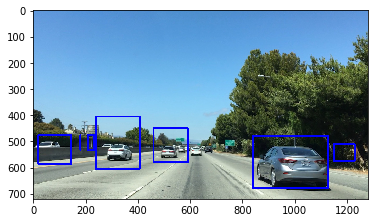

In [16]:
heatmap_sum = np.zeros((720,1280)).astype(np.float64)
heatmaps = []

image = mpimg.imread('test_images/bbox-example-image.jpg')
#image = mpimg.imread('test_images/test3.jpg')
result = pipeline(image)
plt.imshow(result)
plt.show()
mpimg.imsave('output_images/bbox-example-pipelineTest.png', result)
#mpimg.imsave('output_images/xxxx.png', result)

## Run pipeline on Test Video

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

############### TEST VIDEO ########################
testVideo_output = "test_video_output.mp4"
testClip = VideoFileClip("test_video.mp4")

heatmap_sum = np.zeros((720,1280)).astype(np.float64)
heatmaps = []

testClip1 = testClip.fl_image(pipeline) #NOTE: this function expects color images!!
%time testClip1.write_videofile(testVideo_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [02:02<00:03,  3.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 2min 2s


### Run pipeline on Project Video

In [18]:
############### PROJET VIDEO ########################
projectVideo_output = "project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")

heatmap_sum = np.zeros((720,1280)).astype(np.float64)
heatmaps = []

clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip.write_videofile(projectVideo_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:08:50<00:03,  3.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 1h 8min 50s
